### STRUCTURE:
 -----------------------

 - pre-process
 - word2vec model
 - Visualise with PCA, TSNE
 - Extract character models(characters with occurence > 1 ~ 400)
 - Model for each book

 


In [6]:
# from src.Data_pre_proc import pre_proc
from gensim.models import word2vec, phrases
from sklearn.manifold import TSNE  
from sklearn.decomposition import PCA
import pandas as pd
import re
import string
from unidecode import unidecode
import matplotlib.pyplot as plt  
import numpy as np
import nltk
from nltk.corpus import stopwords

from modules import components
from modules import Data_pre_proc

In [3]:
f_df = pd.read_csv("../data/csv/c_b_t.csv", encoding='utf-8')

f_df['Text'] = f_df['Text'].apply(lambda x : re.sub("'s", "", (x)))

In [ ]:
f_df = Data_pre_proc.pre_proc(f_df)

In [130]:
f_df.head()

,Chapter,Book,Text
0,Invocation,Book,praise valmiki bird charming song mounts poesy...
1,Canto I. Nárad.,Book I.,om sainted narad prince whose lore words wisdo...
2,Canto II. Brahmá's Visit,Book I.,valmiki graceful speaker heard highest admirat...
3,Canto III. The Argument.,Book I.,hermit watchful heed received poem pregnant se...
4,Canto IV. The Rhapsodists.,Book I.,"end tale brought rose sage mind thought; ""now ..."


In [132]:
dictofbooks = components.books_to_text()
len(dictofbooks)

7

In [133]:
book_seq = f_df.Text.to_list()

In [134]:
def get_corpus(texts):
    cor = [t.split(" ") for t in texts] # list of list of tokens(words)
    corpus = []
    for line in cor:
        l = []
        for x in line: # word in chapter
            if(x != ""):
                l.append(x)
        corpus.append(l)
    return corpus


## For All Books

In [135]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [174]:
texts = book_seq
corpus = get_corpus(texts)
bigrams = phrases.Phrases(corpus)


In [175]:
# model wothout bigram
model = word2vec.Word2Vec(corpus, vector_size=300, window=5, min_count=1, workers=cores-1)
model.save("w2v0.model")

In [156]:
# bigram_model = model
# bigram_model_counter = {}
# for idx in model.wv.index_to_key:
#     if idx not in stopwords.words("english"):
#         if len(idx.split("_")) > 1:
#             bigram_model_counter.update({idx: bigram_model.wv.get_vecattr(idx, "count")})


In [173]:
# mydict = dict(sorted(bigram_model_counter.items(), key=lambda item: item[1], reverse=True))
# mydict


{'raghu_son': 188,
 '"_spoke': 94,
 '"_cried': 87,
 'son_raghu': 79,
 '"_ceased': 69,
 'words_like': 60,
 'maithil_dame': 52,
 'king_sugriva': 47,
 'lord_men': 46,
 'made_reply': 42,
 'like_indra': 42,
 'every_side': 41,
 'queen_kaikeyi': 38,
 'power_might': 36,
 'side_side': 36,
 'far_away': 35,
 'let_us': 35,
 'fain_would': 32,
 'vanar_race': 32,
 'go_forth': 31,
 '"_said': 30,
 'mine_eyes': 30,
 'lord_indra': 30,
 '"_spake': 30,
 'maithil_lady': 29,
 'raghu_sons': 29,
 'janak_child': 28,
 'looked_upon': 28,
 'mighty_bow': 27,
 'answer_made': 27,
 'dandak_wood': 26,
 'vanar_chief': 25,
 'drew_near': 24,
 'suppliant_hands': 24,
 'mighty_arm': 23,
 'sumitra_son': 23,

---------------------------------------------------

In [176]:
m0 = word2vec.Word2Vec.load("w2v0.model")

In [28]:
# texts = book_seq
# corpus = get_corpus(texts)
# bigrams = phrases.Phrases(corpus)
# model = word2vec.Word2Vec(bigrams[corpus], vector_size=300, window=5, min_count=1, workers=4)
# w2v_model.train(book_seq, total_examples=model.corpus_count, epochs=30, report_delay=1)
# model.save("w2v_new.model")


### Visualise

In [29]:
# m0 = word2vec.Word2Vec.load("w2v_new.model")

In [177]:
m0.wv.get_vecattr("rama", "count")

1751

In [178]:
[(item[0],round(item[1],2)) for item in m0.wv.most_similar('sita')]  


[('vibhishan', 1.0),
 ('dame', 1.0),
 ('tell', 1.0),
 ('angad', 1.0),
 ('faithful', 1.0),
 ('joy', 1.0),
 ('sake', 1.0),
 ('forth', 1.0),
 ('moved', 1.0),
 ('word', 1.0)]

> from components

In [179]:
def get_pca(m0):
    vocab = list(m0.wv.key_to_index)
    X = m0.wv[vocab]  #vectors
    pca = PCA(n_components=3, random_state=11, whiten=True) #reducing 300 dimensions to 3
    clf = pca.fit_transform(X)
    pca_tmp = pd.DataFrame(clf, columns = ['x','y','z'])
    pca_tmp.insert(0, 'Character',vocab)
    return pca_tmp

In [180]:
def plot_pca(pca_tmp):   
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca_tmp['x'], pca_tmp['y'], pca_tmp['z'], alpha=0.5)

    for idx, row in pca_tmp.iterrows():
        char, x, y, z = row
        pos = (x, y, z)
        ax.text(x, y, z, s=char, size = 10, zorder=1, color='k')
    plt.title("w2v-PCA-books")
    plt.show()

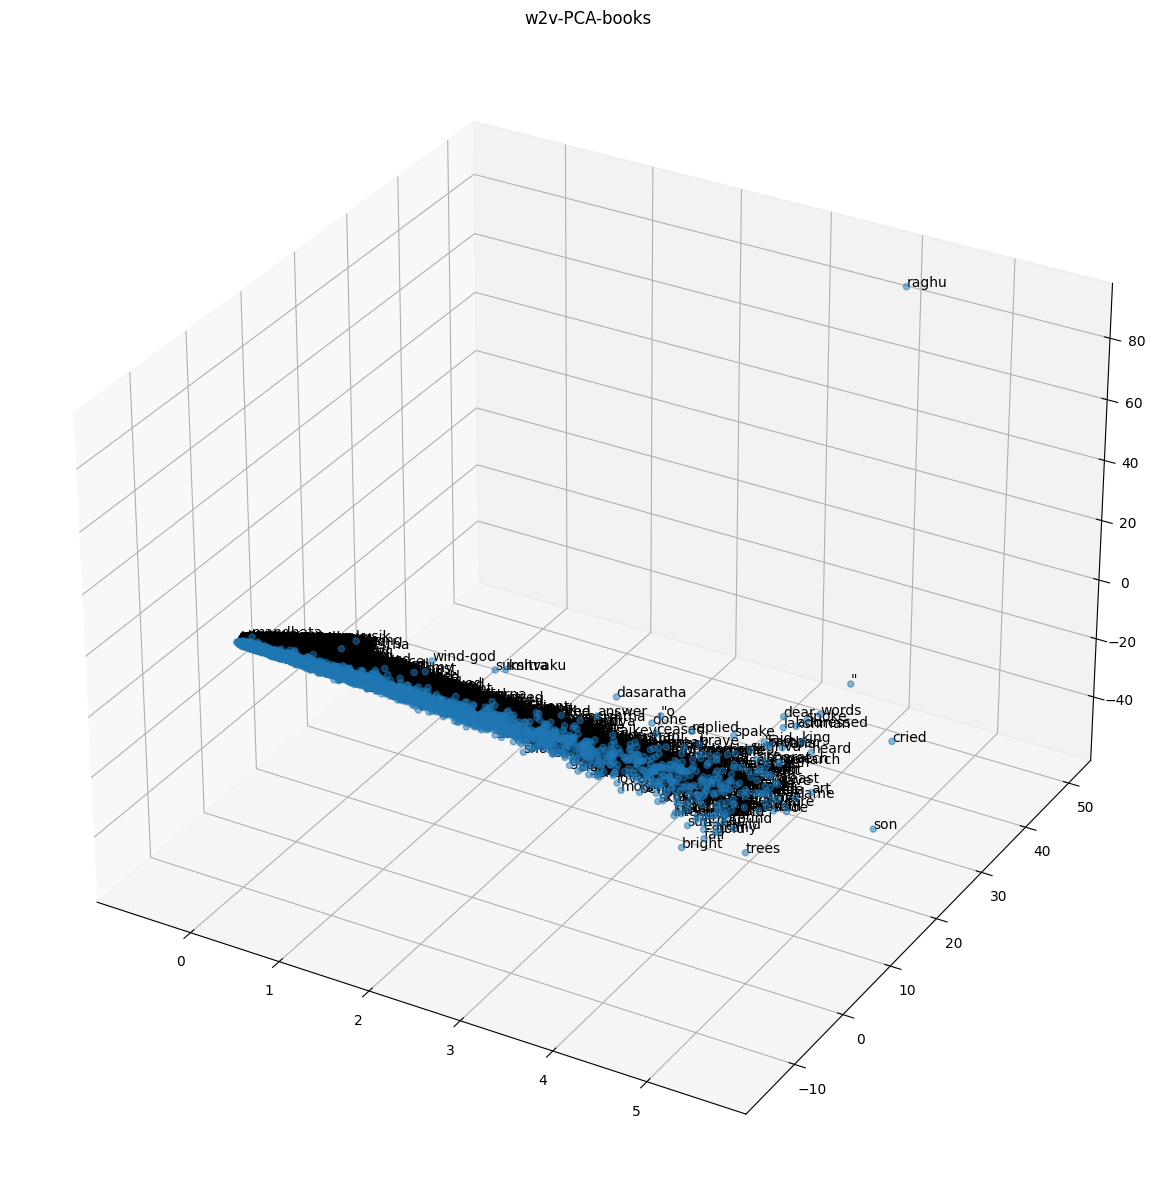

In [181]:
pca_tmp = get_pca(m0)    
plot_pca(pca_tmp)

In [188]:
def get_tsne(m0):
    vocab = list(m0.wv.key_to_index)
    X = m0.wv[vocab]
    tsne = TSNE(n_components=3, random_state=11, n_jobs=-1, verbose=1)
    clf = tsne.fit_transform(X)

    tsne_tmp = pd.DataFrame(clf, columns = ['x','y','z'])
    tsne_tmp.insert(0, 'Character',vocab)

    tsne_tmp.head(3)
    return tsne_tmp


In [189]:
def plot_tsne(tsne_tmp):
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(tsne_tmp['x'], tsne_tmp['y'], tsne_tmp['z'], alpha = 0.5)

    for word, row in tsne_tmp.iterrows():
        char, x, y, z = row
        pos = (x, y, z)
        ax.text(x, y, z, s=char, size=8, zorder=1, color='k')

    plt.title('w2v map - t-SNE')
    plt.show()


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 13507 samples in 0.002s...
[t-SNE] Computed neighbors for 13507 samples in 2.819s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13507
[t-SNE] Computed conditional probabilities for sample 2000 / 13507
[t-SNE] Computed conditional probabilities for sample 3000 / 13507
[t-SNE] Computed conditional probabilities for sample 4000 / 13507
[t-SNE] Computed conditional probabilities for sample 5000 / 13507
[t-SNE] Computed conditional probabilities for sample 6000 / 13507
[t-SNE] Computed conditional probabilities for sample 7000 / 13507
[t-SNE] Computed conditional probabilities for sample 8000 / 13507
[t-SNE] Computed conditional probabilities for sample 9000 / 13507
[t-SNE] Computed conditional probabilities for sample 10000 / 13507
[t-SNE] Computed conditional probabilities for sample 11000 / 13507
[t-SNE] Computed conditional probabilities for sample 12000 / 13507
[t-SNE] Computed conditional probabilities for sam

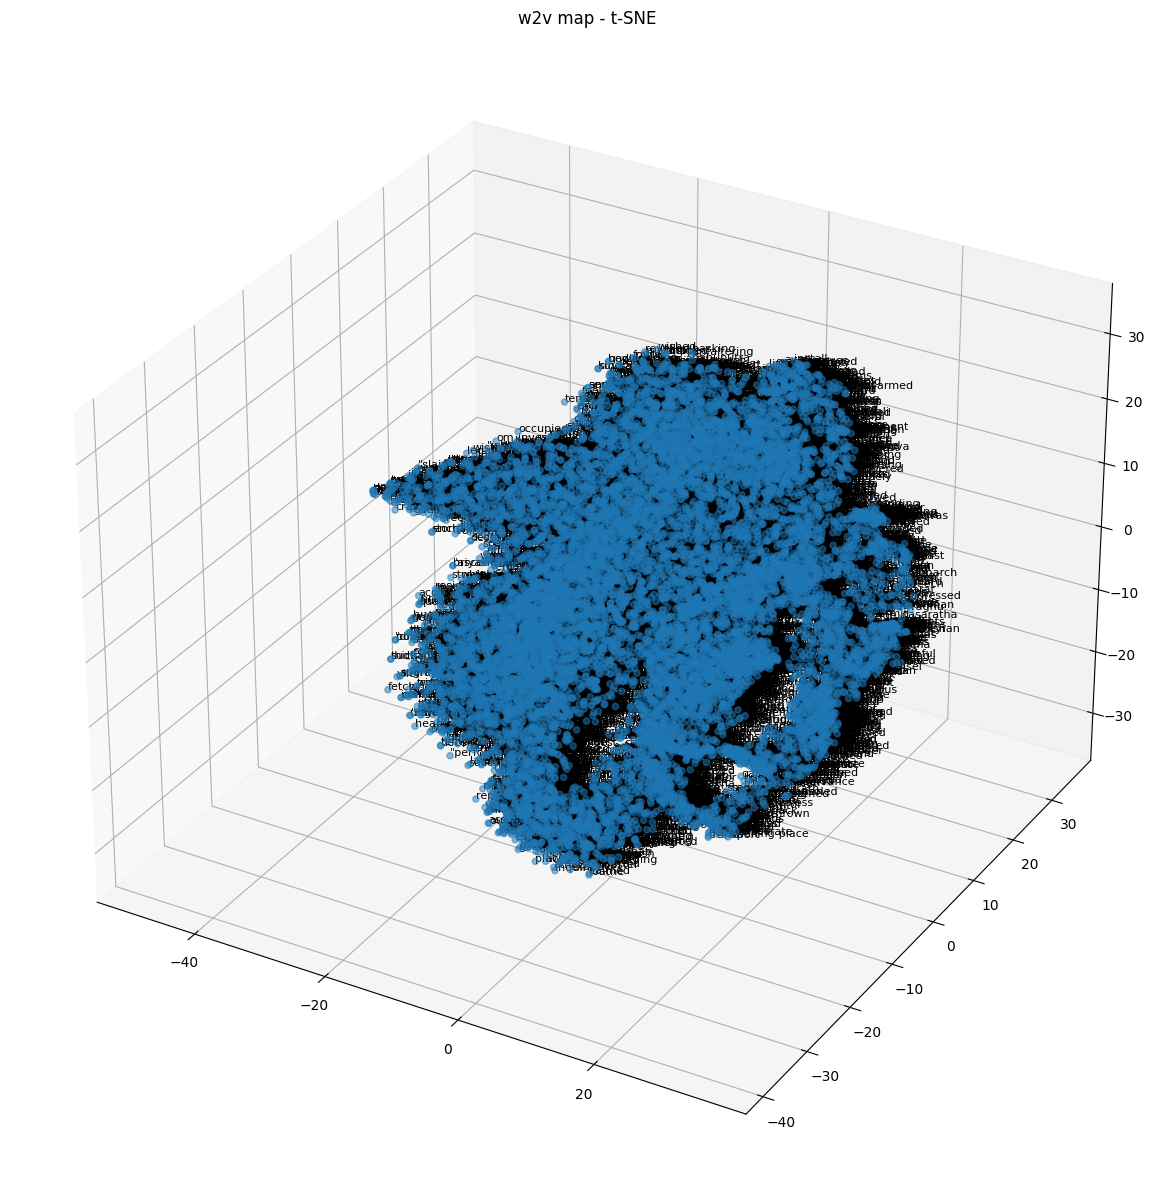

In [190]:
tsne_tmp = get_tsne(m0)
plot_tsne(tsne_tmp)

#### Only for Chars

In [194]:
def get_char_list():
    ch = open("/kaggle/input/idkwhatiamdoing/chars.txt", 'r', encoding='utf-8')
    chs = ch.readlines()
    c_list = []
    characters = []
    for line in chs:
        line = line.strip().replace(".", "")
        components = line.split(",")
        charac = components[0]
        occ = components[1:]
        if (bool(re.search('[0-9]+', charac)) == False) and (charac != ""):
            characters.append(charac)
        c_list.append({ "Character": components[0], "Occurences" : occ})
    return characters


In [195]:
#returns list of characters with appearences more than 1, and presence in vocab w2v
def chars_in_each_book(model):
    c_list = get_char_list()
    chars_in_book = [] #characters in a book with apperances > 1
    for char in c_list:
        try:
            if(model.wv.get_vecattr(unidecode(char.lower()), "count") > 1):
                chars_in_book.append(unidecode(char.lower()))
        except:
            continue
    return(chars_in_book)


In [196]:
"""Remove all tokens from vocab that are not characters"""
def only_chars(m0, tmp): # model corresponding to book
    chars_in_b = chars_in_each_book(m0)
    for idx, row in tmp.iterrows():
        if row["Character"] not in chars_in_b:
            tmp = tmp.drop(idx)
    return tmp

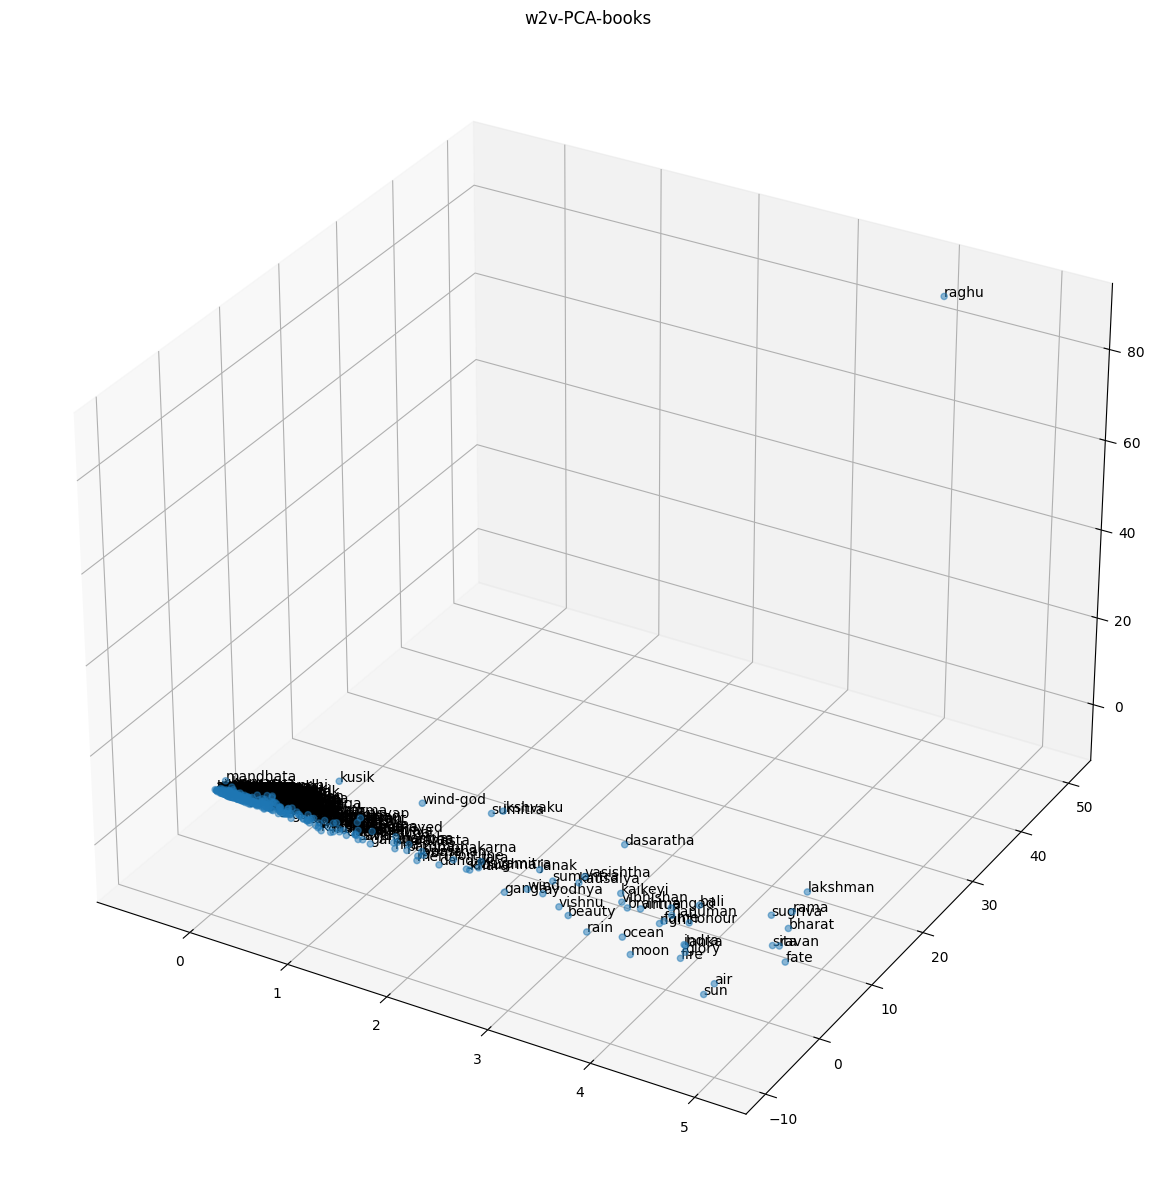

In [197]:
pca_tmp = only_chars(m0, pca_tmp)
plot_pca(pca_tmp)

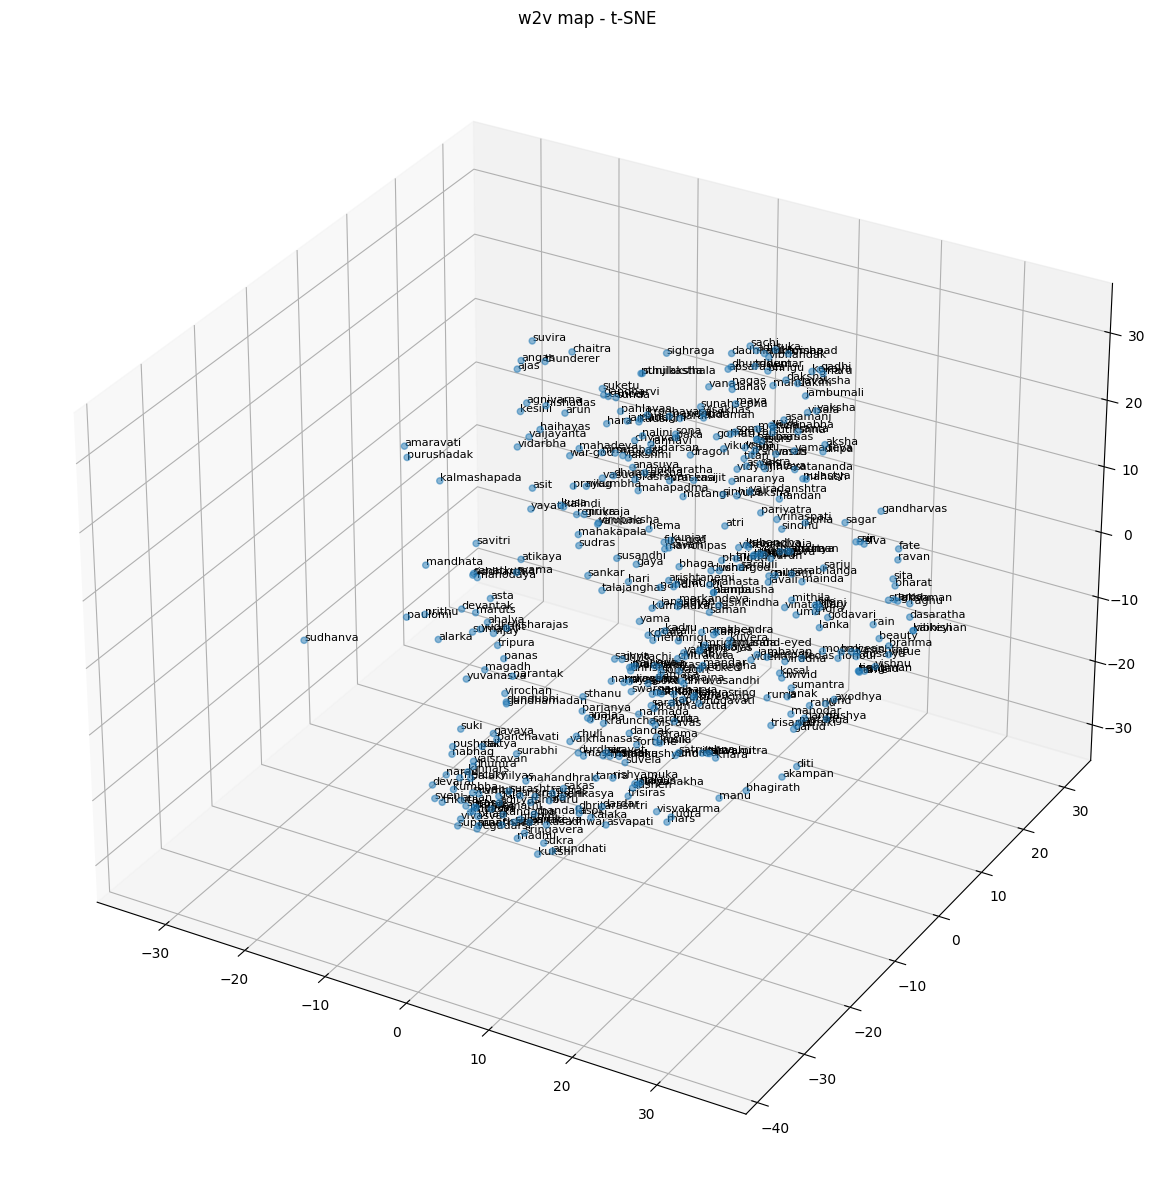

In [199]:
"""Remove all tokens from vocab that are not characters"""
tsne_tmp = only_chars(m0, tsne_tmp)
tsne_tmp.head()
plot_tsne(tsne_tmp)

## For Each Book

In [76]:
models = []
# chars = components.get_char_list()[0]
for key in dictofbooks:
    texts = dictofbooks[key] # dict of list of strings
    # texts can be any list of strings(documents)
    corpus = get_corpus(texts) # gives a list of list of strings
    bigrams = phrases.Phrases(corpus)
    model = word2vec.Word2Vec(bigrams[corpus], vector_size=300, window=5, min_count=1, workers=4)  
    models.append(model)


In [77]:
m1 = models[1]
m2 = models[2]
m3 = models[3]
m4 = models[4]
m5 = models[5]
m6 = models[6]

In [80]:
[(item[0],round(item[1],2)) for item in m3.wv.most_similar('sita')]  

[('rama', 1.0),
 ('see', 1.0),
 ('still', 1.0),
 ('eyes', 1.0),
 ('lord', 1.0),
 ('whose', 1.0),
 ('"', 1.0),
 ('lakshman', 1.0),
 ('like', 1.0),
 ('giant', 1.0)]

[('cried', 1.0),
 ('sugriva', 1.0),
 ('dame', 1.0),
 ('prince', 1.0),
 ('said', 1.0),
 ('meet', 1.0),
 ('bharat', 1.0),
 ('near', 1.0),
 ('raghu_son', 1.0),
 ('lady', 1.0)]